<a href="https://colab.research.google.com/github/nedokormysh/Stepik_Ai_edu_RNN/blob/week_5_char_RNN/RNN_classification_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RNN своими руками

Ноутбук сделан по мотивам [ноутбука из документации PyTorch](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

In [14]:
%matplotlib inline


В этом ноутбуке при помощи классической RNN мы будем решать задачу классификации: будем определять, к какому языку относится то или иное имя.

Загрузим [архив с данными](https://disk.yandex.ru/d/o1v3K9sCG5JN5w) для задачи и распакуем его.

In [15]:
from zipfile import ZipFile

zip = ZipFile('names.zip')
zip.extractall()

В следующих трех ячейках происходит доступ к данным в файлах и их обработка.

In [16]:
from io import open
import glob
import os

def findFiles(path):
    return glob.glob(path)

print(findFiles('names/*.txt'))

['names/Czech.txt', 'names/Portuguese.txt', 'names/Chinese.txt', 'names/Japanese.txt', 'names/Vietnamese.txt', 'names/Greek.txt', 'names/German.txt', 'names/English.txt', 'names/Spanish.txt', 'names/French.txt', 'names/Korean.txt', 'names/Russian.txt', 'names/Italian.txt', 'names/Dutch.txt', 'names/Irish.txt', 'names/Arabic.txt', 'names/Scottish.txt', 'names/Polish.txt']


In [17]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Перевод Unicode в Ascii https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [18]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

Теперь у нас есть:

* Словарь `category_lines` - ключом является язык (записанный на английском языке с большой буквы), а значениями - имена из этого языка

* `all_categories` - список всех имеющихся языков

* `n_categories` - число языков.




## Задание

Какое имя находится вторым по счету в списке французских имен?

In [19]:
category_lines['French'][1]

'Abraham'

### Переведем имена в тензоры

Закодируем каждую букву при помощи one-hot кодирования.
Например,
``"b" = <0 1 0 0 0 ...>`` и так далее.

Тогда слово - это будет матрица, где в каждой строке находится one-hot вектор букв слова. Матрица будет размера ``<line_length x 1 x n_letters>``.

Размерность `1` мнимая, она нужна нам, так как PyTorch работает с объектами по батчам - мы будем использовать "батчи из одного объекта".



In [20]:
# import unicodedata
# import string

# all_letters = string.ascii_letters + " .,;'"
# n_letters = len(all_letters)

# # Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
# def unicodeToAscii(s):
#     return ''.join(
#         c for c in unicodedata.normalize('NFD', s)
#         if unicodedata.category(c) != 'Mn'
#         and c in all_letters
#     )

# print(unicodeToAscii('Ślusàrski'))

Slusarski


In [25]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Создание RNN

Опишем архитектуру класического RNN-блока:

Первый линейный слой (обновление скрытого состояния ячейки):

* На вход в первый линейный (полносвязный) слой поступает вектор размера `input_size + hidden_size`, где `input_size` - длина one-hot вектора буквы, а `hidden_size` - количество нейронов в скрытом состоянии ячейки: на вход слою подается сконкатенированный вектор слова `x` и вектор скрытого состояния `a`.

* На выходе из слоя получаем `hidden_size` число нейронов

После первого линейного слоя в классической RNN применяется функция активации tanh - здесь для простоты обойдемся без нее. Затем следует второй линейный слой.

Второй линейный слой (получение прогноза):

* На вход поступает `n_hidden` число нейронов, на выход - `output_size` нейронов (равное числу языков в данных).

* После выхода из этого слоя применяется функция активации `softmax`. Так как наш лосс будет [NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html), то лучше использовать активацию `LogSoftmax`.


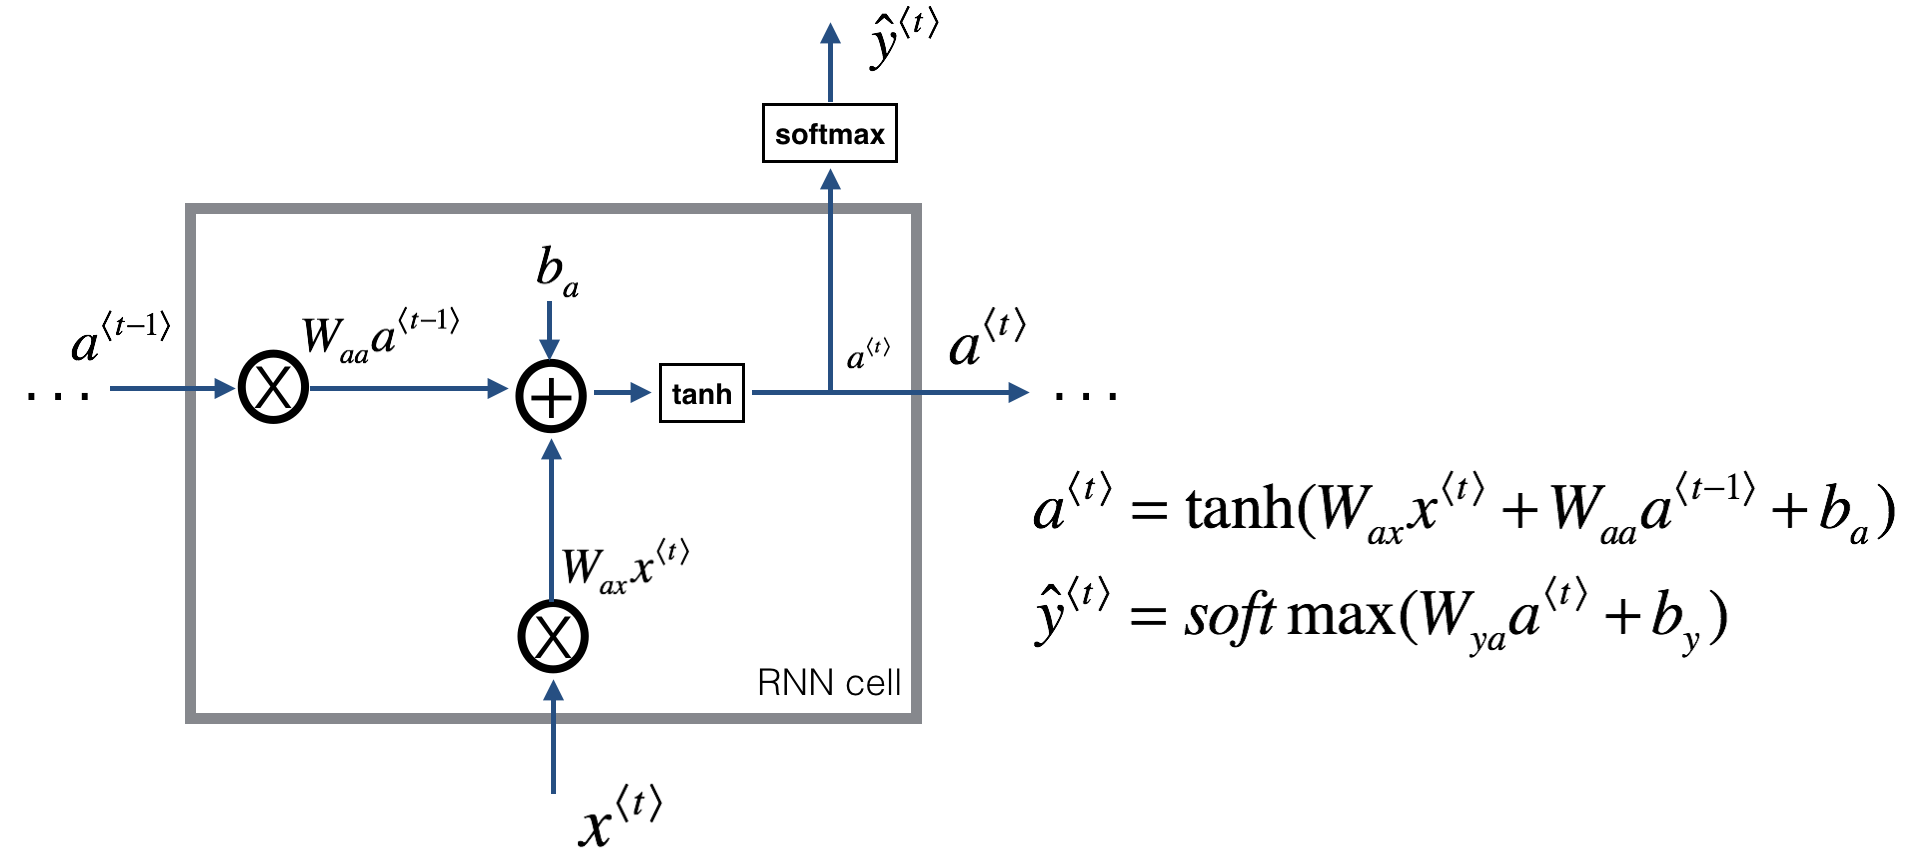

## Задание

Допишите модуль RNN по описанию выше.

Затем объявите `n_hidden = 128` и создайте ячейку RNN с гиперпараметрами `n_letters, n_hidden, n_categories`. Назовите ее `rnn`.

Сколько признаков поступает в первый линейный слой `rnn`?

In [22]:
import torch
import torch.nn as nn

In [44]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) # конкатенируем векторы input и hidden и далее подаем в сеть

        hidden = self.i2h(combined) # первый слой
        output = self.h2o(hidden) # второй слой
        output = self.softmax(output) # применяем функцию активации к второму слою

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [55]:
n_letters + n_hidden

185

## Задание

В нашу `rnn`-ячейку нужно передавать входной символ и предыдущее скрытое состояние. На первом шаге скрытое состояние - это вектор из нулей.

Допишите код, который передает в RNN букву 'D' и выведите на экран цифру (без знака), на которую начинается большинство координат вектора-прогноза (`output`).

P.S. Не забудьте перевести букву в тензор нужного формата, используя написанную выше функцию `letterToTensor`.

In [52]:
input = letterToTensor('D')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [53]:
output

tensor([[-2.3985, -3.7289, -3.6640, -3.3308, -3.0630, -3.8566, -2.2418, -2.2808,
         -3.2929, -2.8357, -3.0265, -2.5984, -3.9171, -2.7001, -2.9302, -2.3640,
         -3.0410, -3.0713]], grad_fn=<LogSoftmaxBackward0>)

Когда мы будем работать с именами, то будем переводить в тензор сразу все имя. Это можно сделать, используя код ниже.

In [46]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8251, -2.9824, -2.9338, -2.8193, -2.8461, -2.8942, -2.8375, -2.9127,
         -2.9212, -2.9018, -2.9165, -2.8761, -2.8401, -2.8917, -2.8489, -2.9196,
         -2.9448, -2.9333]], grad_fn=<LogSoftmaxBackward0>)


## Обучение

Перед тем как приступить к обучению, нам необходимо создать вспомогательные функции.

`categoryFromOutput` - функция, переводящая прогноз модели (набор вероятностей) в класс, то есть, возвращающая название языка и его номер.



In [47]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 3)


Функция `randomTrainingExample` выдает случайный язык из данных и имя из этого языка.

In [48]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Chinese / line = Hiu
category = Czech / line = Antonowitz
category = Italian / line = Pesce
category = Dutch / line = Houtum
category = English / line = Loft
category = Greek / line = Papoutsis
category = Spanish / line = Bello
category = French / line = Victors
category = Chinese / line = Wan
category = Japanese / line = Nakata


### Обучение сети.

Мы будем использовать `NLLLoss` (negative log-likelihood loss). Объявите его.



In [49]:
criterion = nn.NLLLoss()

## Задание

Допишите функцию обучения сети по подсказкам в коде ниже.

In [50]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden() # инициализируйте веса сети rnn, используя метод init_hidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden) # на каждой итерации передавайте в сеть очередное слово (с индексом i) и скрытое состояние сети

    loss = criterion(output, category_tensor) # вычислите loss
    loss.backward() # вычислите градиенты методом обратного распространения ошибки

    # делаем шаг градиентного спуска
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Запустите код ниже. Если функция `train` написана корректно, то код отработает без ошибок.

Сколько строк напечатано на экране в результате работы кода?

In [51]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.6400 Michel / Vietnamese ✗ (German)
10000 10% (0m 14s) 1.1691 Hung / Vietnamese ✗ (Korean)
15000 15% (0m 20s) 2.0088 Frost / French ✗ (German)
20000 20% (0m 28s) 1.4907 Ganem / Arabic ✓
25000 25% (0m 35s) 0.7278 Rijnders / Dutch ✓
30000 30% (0m 44s) 3.1208 Wiesner / German ✗ (Czech)
35000 35% (0m 51s) 0.7267 Souza / Portuguese ✓
40000 40% (0m 58s) 0.0666 Nakata / Japanese ✓
45000 45% (1m 5s) 1.8421 Jia / Spanish ✗ (Chinese)
50000 50% (1m 13s) 0.9311 Fabron / French ✓
55000 55% (1m 20s) 0.5299 Shamoun / Arabic ✓
60000 60% (1m 27s) 4.3899 Plimak / Polish ✗ (Russian)
65000 65% (1m 34s) 3.1991 Kosmas / Arabic ✗ (Greek)
70000 70% (1m 41s) 1.5787 Yun / Korean ✗ (Chinese)
75000 75% (1m 49s) 0.2988 Cearbhall / Irish ✓
80000 80% (1m 55s) 0.0831 Traversini / Italian ✓
85000 85% (2m 3s) 0.0042 Donnchadh / Irish ✓
90000 90% (2m 10s) 0.2908 O'Mooney / Irish ✓
95000 95% (2m 17s) 0.3864 Donovan / Irish ✓
100000 100% (2m 24s) 0.0251 Aswad / Arabic ✓


## Задание (отрисовка результатов)

Нарисуйте график лосса, используя список `all_losses`.
Как ведет себя график?


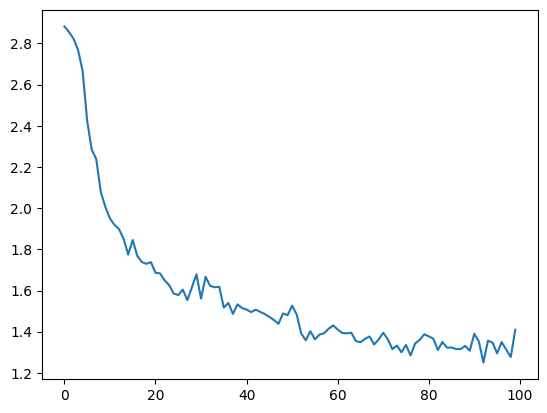

In [56]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Оценка качества модели

Функция `evaluate` - возвращает прогноз модели на конкретном слове (переведенном в тензор).


In [57]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

## Задание

Допишите цикл применения модели по комментариям в коде ниже.

Какой из языков классифицируется моделью лучше всего?

<ipython-input-58-9ab8224254ac>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-58-9ab8224254ac>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


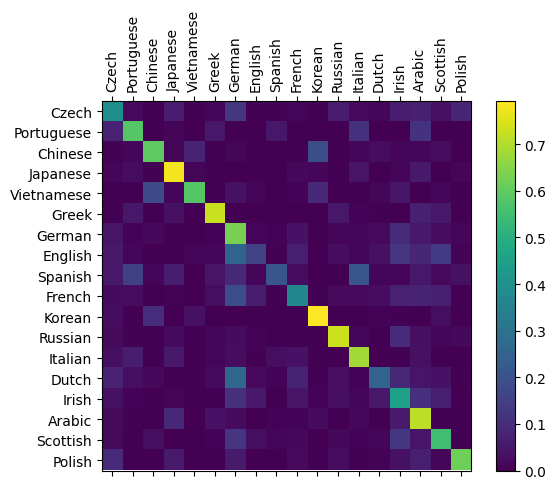

In [58]:
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor) # примените модель к line_tensor
    guess, guess_i = categoryFromOutput(output) # переведите прогноз в класс, используя функцию categoryFromOutput
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Нормализуем матрицу оценок
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Рисуем матрицу
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

### Запуск модели на новых именах (введенных пользователем)




In [59]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

## Задание

Запустите модель на своем имени, записанном транслитом. Правильно ли модель справилась с определением происхождения вашего имени?

In [60]:
predict('Ilya')


> Ilya
(-0.59) Japanese
(-1.46) Polish
(-2.11) Czech


In [61]:
predict('Berezutskiy')


> Berezutskiy
(-0.64) Russian
(-0.93) Irish
(-3.31) English
